### This script creates a map of a cloud band and shows the properties: orientation, centroid and ellipse around the cloud band (blob)

#### Importation of appropriate packages

In [1]:
import datetime as dt
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, ConnectionPatch
from matplotlib.ticker import MultipleLocator

from skimage import measure

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")

from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config
from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.misc import wrapTo180
from cloudbandpy.tracking import tracking, findCloud

warnings.filterwarnings("ignore")

In [2]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20210226.00"
config_event["enddate"] = "20210228.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False
config_event["lon_east"] = 280

2023-11-29 10:56:28,499 - io_utilities.load_ymlfile - INFO: Configuration file loaded


In [3]:
olr2process, parameters, listofdates, lats, lons, resolution = run_load_data(
    config_event
)

2023-11-29 10:56:28,506 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-11-29 10:56:28,510 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-11-29 10:56:28,542 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2023-11-29 10:56:28,543 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2023-11-29 10:56:30,620 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-11-29 10:56:30,622 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-11-29 10:56:30,709 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-11-29 10:56:30,710 - io_utilities.load_dataset - INFO: Dataset loaded


In [4]:
(
    _,
    _,
    _,
    _,
    _,
    list_of_candidates,
    list_of_cloudbands,
) = detection_workflow(
    var2process=olr2process,
    parameters=parameters,
    latitudes=lats,
    longitudes=lons,
    resolution=resolution,
    listofdates=listofdates,
    config=config,
)

2023-11-29 10:56:30,763 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-11-29 10:56:30,940 - cb_detection.detection_workflow - INFO: Cloud band detection done


In [5]:
list_of_cloud_bands = tracking(list_of_cloudbands, resolution, overlapfactor=parameters["othresh"])

2023-11-29 10:56:30,945 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2023-11-29 10:56:30,948 - cloudbandpy.tracking - INFO: Inheritance tracking done


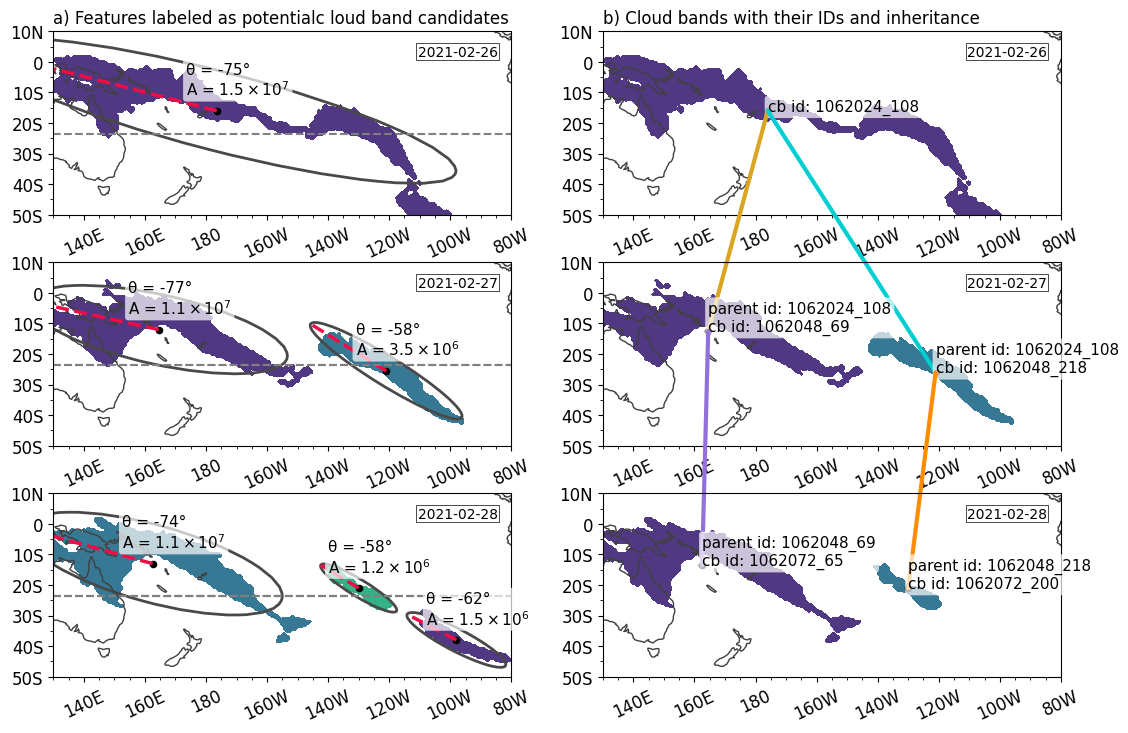

In [6]:
set_fontsize(12)

fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(13, 8.5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)

for inc, ax in enumerate(axs[:, 0]):
    if inc == 0:
        title = ax.set_title(
            "a) Features labeled as potentialc loud band candidates",
            fontsize=12,
            loc="left",
        )
        title.set_position([0, 1.05])
    ax.text(
        0.97,
        0.85,
        listofdates[inc].strftime("%Y-%m-%d"),
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
        zorder=1,
        bbox={
            "facecolor": "white",
            "edgecolor": "k",
            "linewidth": 0.5,
            "pad": 1.0,
        },
        fontsize=10,
    )
    for i, cb in enumerate(list_of_candidates[inc]):
        cbmap = (i + 1) * cb.cloud_band_array
        masked_map = np.ma.masked_where(cbmap == 0, cbmap)
        ax.contourf(
            lons,
            lats,
            masked_map,
            transform=ccrs.PlateCarree(),
            levels=range(5),
            alpha=0.95,
        )
        for props in measure.regionprops(cb.cloud_band_array):
            centroid = props.centroid
            x_centroid, y_centroid = (
                lons[int(centroid[1])].item(),
                lats[int(centroid[0])].item(),
            )

            # Extract ellipse properties
            major_axis_length = props.major_axis_length
            minor_axis_length = props.minor_axis_length
            orientation = props.orientation
            angle_deg = (orientation * 360) / (2 * np.pi)

            ax.scatter(
                x_centroid,
                y_centroid,
                color="k",
                marker="o",
                s=20,
                transform=ccrs.PlateCarree(),
            )

            # Create and plot the ellipse with proper orientation
            ellipse = Ellipse(
                (x_centroid, y_centroid),
                width=major_axis_length * 0.5,
                height=minor_axis_length * 0.5,
                angle=angle_deg - 90,
                edgecolor="#494949",
                facecolor="none",
                linewidth=2,
                transform=ccrs.PlateCarree(),
            )
            ax.add_patch(ellipse)

            # Plot major and minor axes using the provided code
            x0, y0 = x_centroid, y_centroid
            x2 = x0 - np.sin(orientation) * 0.25 * major_axis_length
            y2 = y0 + np.cos(orientation) * 0.25 * major_axis_length

            ax.plot(
                (x0, x2),
                (y0, y2),
                "--",
                color="#f10c45",
                linewidth=2.5,
                transform=ccrs.PlateCarree(),
            )
            notation = "{:e}".format(int(cb.area))
            base, exponent = notation.split("e")

            # Get the x and y coordinates of the clicked point
            area_string = rf"${round(float(base), 1)} \times 10^{{{int(exponent)}}}$"
            ax.text(
                x0 - 10,
                y0 + 5,
                f"θ = -{int(angle_deg)}°\nA = {area_string}",  # km$^{{2}}$",
                color="k",
                backgroundcolor="white",
                transform=ccrs.PlateCarree(),
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.7,
                    boxstyle="round,pad=0.2",
                ),
                fontsize=11,
            )
            ax.axhline(y=-23.5, color="gray", linestyle="--")


colors = [
    "goldenrod",
    "darkturquoise",
    "mediumpurple",
    "darkorange",
    "red",
    "blue",
    "yellowgreen",
]
cid = 0
for inc, ax in enumerate(axs[:, 1]):
    if inc == 0:
        title = ax.set_title(
            "b) Cloud bands with their IDs and inheritance", fontsize=12, loc="left"
        )
        title.set_position([0, 1.05])
    map = list_of_cloud_bands[inc][0].cloud_band_array
    for i, m in enumerate(list_of_cloud_bands[inc][1:]):
        map = map + (i + 2) * m.cloud_band_array
    masked_map = np.ma.masked_where(map == 0, map)
    ax.contourf(
        lons,
        lats,
        masked_map,
        transform=ccrs.PlateCarree(),
        levels=range(5),
        alpha=0.95,
    )
    ax.text(
        0.97,
        0.85,
        listofdates[inc].strftime("%Y-%m-%d"),
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
        zorder=1,
        bbox={
            "facecolor": "white",
            "edgecolor": "k",
            "linewidth": 0.5,
            "pad": 1.0,
        },
        fontsize=10,
    )
    for ii, cloud in enumerate(list_of_cloud_bands[inc]):
        y0, x0 = cloud.latloncenter
        lon0 = lons[round(x0)]
        lat0 = lats[round(y0)]
        xyA = ccrs.PlateCarree(central_longitude=180).transform_point(
            lon0, lat0, ccrs.PlateCarree()
        )
        ax.scatter(
            lon0,
            lat0,
            color="k",
            marker="o",
            s=20,
            transform=ccrs.PlateCarree(),
        )
        if cloud.parents:
            ax.text(
                lon0,
                lat0,
                f"parent id: {', '.join(str(e.id_) if hasattr(e, 'id_') else str(e) for e in cloud.parents)}\ncb id: {cloud.id_}",
                color="k",
                backgroundcolor="white",
                transform=ccrs.PlateCarree(),
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.7,
                    boxstyle="round,pad=0.2",
                ),
                fontsize=11,
            )
        else:
            ax.text(
                lon0,
                lat0,
                f"cb id: {cloud.id_}",
                color="k",
                backgroundcolor="white",
                transform=ccrs.PlateCarree(),
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.7,
                    boxstyle="round,pad=0.2",
                ),
                fontsize=11,
            )
        for parent_id in cloud.parents:
            parent = findCloud(list_of_cloud_bands, parent_id)
            if parent:
                y1, x1 = parent.latloncenter
                lon1 = lons[round(x1)]
                lat1 = lats[round(y1)]
                xyB = ccrs.PlateCarree(central_longitude=180).transform_point(
                    lon1, lat1, ccrs.PlateCarree()
                )
                con = ConnectionPatch(
                    xyA=xyA,
                    xyB=xyB,
                    coordsA="data",
                    coordsB="data",
                    axesA=ax,
                    axesB=axs[:, 1][
                        inc - 1
                    ],  # Connect to the previous panel in the same column
                    color=colors[cid % len(colors)],
                    linewidth=3,
                    zorder=2,
                )
                cid += 1
                ax.add_artist(con)


for i, ax in enumerate(axs.ravel()):
    lat_north, lat_south = 10, -50
    lonticks = np.concatenate((np.arange(0, 180, 20), np.arange(-180, 0, 20)))
    latticks = np.arange(-50, 20, 10)
    ax.set_yticks(latticks, crs=ccrs.PlateCarree())
    ax.set_xticks(lonticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(lonticks, rotation=25)
    ax.xaxis.set_major_formatter(LON_FORMAT)
    ax.yaxis.set_major_formatter(LAT_FORMAT)
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.coastlines("110m", color="#404040")
    ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
    ax.set_ylim([lat_south, lat_north])
    original_startdate = config_event["startdate"]
    datetime_obj = dt.datetime.strptime(original_startdate, "%Y%m%d.%H")
    formatted_startdate = datetime_obj.strftime("%Y-%m-%d")


# plt.savefig(
#     f"./properties_series_of_blobs_{formatted_startdate}.png",
#     dpi=200,
#     bbox_inches="tight",
# )